In [14]:
import shutil
import os
path = './../../NNProject_Data/train/'
for each_dir in os.listdir(path):
    count = 0
    os.mkdir('./train/'+each_dir)
    for each_file in os.listdir(os.path.join(path, each_dir)):
        shutil.copy(os.path.join(path, each_dir, each_file), './train/'+each_dir)
        count += 1
        if(count == 30):
            break

Import the libraries required for the project.

In [9]:
import tensorflow as tf
from tensorflow import image as img
import os
import shutil, sys
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import random
from keras.utils.vis_utils import plot_model

List the all the directory paths. The train data is split into two parts. 30 imgaes from each class were randomly chosen to generate the validation data. Training data is in train directory, validation data is in validation directory.

In [2]:
base_dir = '../NNProject_Data'
train_dir = os.path.join(base_dir, 'train/')
val_dir = os.path.join(base_dir, 'validation/')
test_dir = os.path.join(base_dir, 'test/')
new_train_dir = "../NNProject_Data/new_train/"

Utility function for reading the metrics from text files saved

In [21]:
def extract_metric(file):
    f = open(file, 'r')
    x = f.readlines()
    f.close()
    loss = []
    acc = []
    val_loss = []
    val_acc = []
    for each_line in x:
        if "loss:" in each_line:
            y = each_line.split("loss:",1)[1]
            y = y.split(' ')
            loss.append(float(y[1]))
        if "acc:" in each_line:
            y = each_line.split("acc:",1)[1]
            y = y.split(' ')
            acc.append(float(y[1]))
        if "val_loss:" in each_line:
            y = each_line.split("val_loss:",1)[1]
            y = y.split(' ')
            val_loss.append(float(y[1]))
        if "val_acc:" in each_line:
            y = each_line.split("val_acc:",1)[1]
            y = y.split(' ')
            val_acc.append(float(y[1].replace('\n', '')))            
    return (loss, acc, val_loss, val_acc)

List of call backs to change the learning rate dynamically. The learning rate reduces by a factor of 0.1 if the validation loss does not reduce for 5 epochs

In [3]:
import keras
callbacks_list = [ 
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
    )
]

Flow from directory data generators available in keras library are used to generate train and validation data. 
The train data is generated by augumenting the train data dynamically while training.

In [6]:
#Train data generator with various aygumentations
rsltn = 196
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True)

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(rsltn , rsltn),
        batch_size= 64,
        shuffle=True,
        class_mode='categorical')

#Validation data generator without any augumentations
val_datagen = ImageDataGenerator(
      rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        val_dir, 
        target_size=(rsltn, rsltn),
        batch_size= 32,
        shuffle=True,
        class_mode='categorical')

Found 4390 images belonging to 12 classes.
Found 360 images belonging to 12 classes.


The Neural network has VGG19 as it's convoution base and a 4 dense layers added on top of it. A dropout layer with dropout rate of 0.2 is added between the first and second dense layers. The training is started with a learning rate of 0.0001. The convolution base is freezed and only the dense network is trained for 60 epochs by changing the learning rate, validation accuracy of 69% is achieved after 60 epochs.

In [17]:
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG19

rsltn = 196
conv_base = VGG19(weights='imagenet', include_top= False, input_shape=(rsltn, rsltn, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))
conv_base.trainable = False
model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 12)                780       
Total para

In [19]:
model.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 196, 196, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 196, 196, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 196, 196, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 98, 98, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 98, 98, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 98, 98, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 49, 49, 128)       0         
__________

In [31]:
#pydot library is not getting imported
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 30,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/30
100/100 [==============================] - 111s 1s/step - loss: 2.2830 - acc: 0.2160 - val_loss: 2.1191 - val_acc: 0.2321
Epoch 2/30
100/100 [==============================] - 109s 1s/step - loss: 1.9878 - acc: 0.3225 - val_loss: 1.8474 - val_acc: 0.3480
Epoch 3/30
100/100 [==============================] - 109s 1s/step - loss: 1.8432 - acc: 0.3594 - val_loss: 1.7363 - val_acc: 0.3682
Epoch 4/30
100/100 [==============================] - 109s 1s/step - loss: 1.7404 - acc: 0.4010 - val_loss: 1.6666 - val_acc: 0.3945
Epoch 5/30
100/100 [==============================] - 109s 1s/step - loss: 1.6651 - acc: 0.4266 - val_loss: 1.5903 - val_acc: 0.4831
Epoch 6/30
100/100 [==============================] - 109s 1s/step - loss: 1.5736 - acc: 0.4466 - val_loss: 1.5334 - val_acc: 0.5000
Epoch 7/30
100/100 [==============================] - 108s 1s/step - loss: 1.5222 - acc: 0.4686 - val_loss: 1.4457 - val_acc: 0.4935
Epoch 8/30
100/100 [==============================] - 106s 1s/step - 

In [16]:
model.save('keras_aug_4_14.h5')

In [17]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 20,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/20
100/100 [==============================] - 113s 1s/step - loss: 0.9705 - acc: 0.6607 - val_loss: 0.9701 - val_acc: 0.6607
Epoch 2/20
100/100 [==============================] - 107s 1s/step - loss: 0.9687 - acc: 0.6544 - val_loss: 0.9846 - val_acc: 0.6520
Epoch 3/20
100/100 [==============================] - 109s 1s/step - loss: 0.9705 - acc: 0.6604 - val_loss: 1.0047 - val_acc: 0.6740
Epoch 4/20
100/100 [==============================] - 112s 1s/step - loss: 0.9726 - acc: 0.6562 - val_loss: 0.9913 - val_acc: 0.6558
Epoch 5/20
100/100 [==============================] - 108s 1s/step - loss: 0.9856 - acc: 0.6535 - val_loss: 0.9673 - val_acc: 0.6639
Epoch 6/20
100/100 [==============================] - 106s 1s/step - loss: 0.9763 - acc: 0.6578 - val_loss: 0.9762 - val_acc: 0.6537
Epoch 7/20
100/100 [==============================] - 111s 1s/step - loss: 0.9776 - acc: 0.6569 - val_loss: 0.9708 - val_acc: 0.6672
Epoch 8/20
100/100 [==============================] - 107s 1s/step - 

In [18]:
model.save('keras_aug_4_14_2.h5')

In [36]:
new_model = keras.models.load_model('keras_aug_4_14_2.h5')
for layer in new_model.layers:
    if layer.name == 'vgg19':
        layer.trainable = False
new_model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
history = new_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 20,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/20
100/100 [==============================] - 113s 1s/step - loss: 1.1057 - acc: 0.6118 - val_loss: 1.0819 - val_acc: 0.6199
Epoch 2/20
100/100 [==============================] - 108s 1s/step - loss: 1.0810 - acc: 0.6173 - val_loss: 1.3265 - val_acc: 0.5405
Epoch 3/20
100/100 [==============================] - 110s 1s/step - loss: 1.0707 - acc: 0.6090 - val_loss: 1.0736 - val_acc: 0.6315
Epoch 4/20
100/100 [==============================] - 108s 1s/step - loss: 1.0512 - acc: 0.6264 - val_loss: 1.2246 - val_acc: 0.5473
Epoch 5/20
100/100 [==============================] - 109s 1s/step - loss: 1.0795 - acc: 0.6203 - val_loss: 0.9940 - val_acc: 0.6655
Epoch 6/20
100/100 [==============================] - 107s 1s/step - loss: 1.0760 - acc: 0.6139 - val_loss: 0.9816 - val_acc: 0.6883
Epoch 7/20
100/100 [==============================] - 108s 1s/step - loss: 1.0342 - acc: 0.6347 - val_loss: 1.0186 - val_acc: 0.6622
Epoch 8/20
100/100 [==============================] - 108s 1s/step - 

Text(0.5, 1.0, 'Accuracy plot for training only the Dense Layers')

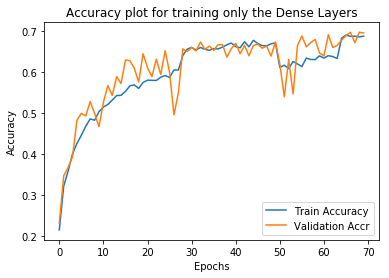

In [24]:
#The metrics of each epoch till this point are stored in train_log file
loss , acc, val_loss, val_acc = extract_metric('train_log_0.txt')
from matplotlib import pyplot as plt
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accr')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy plot for training only the Dense Layers')

Text(0.5, 1.0, 'Loss values plot during training the Dense Layers')

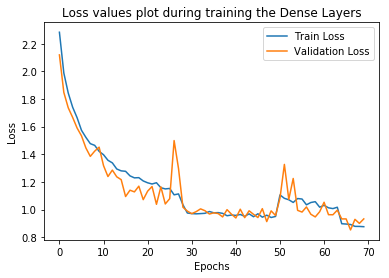

In [26]:
#The metrics of each epoch till this point are stored in train_log file
loss , acc, val_loss, val_acc = extract_metric('train_log_0.txt')
from matplotlib import pyplot as plt
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss values plot during training the Dense Layers')

In [39]:
new_model.save('keras_aug_4_15_1.h5')

# Fine tuning Convolution Block 5

To increase the accuracy further the last convolutional block of the VGG19 conv base is unfrozen and the model is trained for 20 epochs to achieve a validation accuracy of 87%

In [70]:
new_model = keras.models.load_model('keras_aug_4_14_2.h5')
for layer in new_model.layers:
    if layer.name == 'vgg19':
        layer.trainable = True
        #print(layer.name)
        for each_layer in layer.layers:
            #print(each_layer.name)
            if each_layer.name == 'block5_conv1' or each_layer.name == 'block5_conv2' or each_layer.name == 'block5_conv3' or each_layer.name == 'block5_conv4':
                each_layer.trainable = True
            else:
                each_layer.trainable = False
new_model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [71]:
new_model.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 196, 196, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 196, 196, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 196, 196, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 98, 98, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 98, 98, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 98, 98, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 49, 49, 128)       0         
__________

In [72]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 12)                780       
Total para

In [77]:
new_model.evaluate_generator(val_generator, steps = 30)

[0.958217390485712, 0.6655405405405406]

In [78]:
history = new_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 20,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/20
100/100 [==============================] - 113s 1s/step - loss: 2.2066 - acc: 0.3037 - val_loss: 1.5946 - val_acc: 0.4088
Epoch 2/20
100/100 [==============================] - 108s 1s/step - loss: 1.3730 - acc: 0.5253 - val_loss: 1.1004 - val_acc: 0.6364
Epoch 3/20
100/100 [==============================] - 108s 1s/step - loss: 1.0314 - acc: 0.6442 - val_loss: 0.8168 - val_acc: 0.7382
Epoch 4/20
100/100 [==============================] - 107s 1s/step - loss: 0.8552 - acc: 0.7045 - val_loss: 1.8828 - val_acc: 0.4696
Epoch 5/20
100/100 [==============================] - 109s 1s/step - loss: 0.7686 - acc: 0.7370 - val_loss: 0.8757 - val_acc: 0.7403
Epoch 6/20
100/100 [==============================] - 109s 1s/step - loss: 0.6842 - acc: 0.7678 - val_loss: 0.5790 - val_acc: 0.8159
Epoch 7/20
100/100 [==============================] - 108s 1s/step - loss: 0.6148 - acc: 0.7910 - val_loss: 0.7545 - val_acc: 0.7804
Epoch 8/20
100/100 [==============================] - 110s 1s/step - 

Text(0.5, 1.0, 'Accuracy plot during fine tuning Conv Block 5')

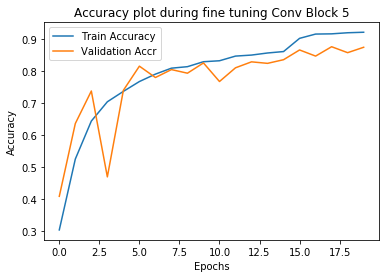

In [27]:
#The metrics of each epoch till this point are stored in train_log file
loss , acc, val_loss, val_acc = extract_metric('fine_tune_log_1.txt')
from matplotlib import pyplot as plt
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accr')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy plot during fine tuning Conv Block 5')

Text(0.5, 1.0, 'Loss plot during fine tuning Conv Block 5')

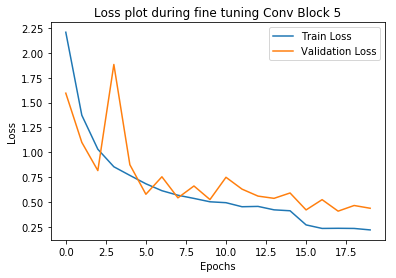

In [29]:
loss , acc, val_loss, val_acc = extract_metric('fine_tune_log_1.txt')
from matplotlib import pyplot as plt
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss plot during fine tuning Conv Block 5')

In [ ]:
new_model.save('keras_aug_4_15_2.h5')

# Fine tuning Convolution Block4

In [110]:
temp_model = keras.models.load_model('keras_aug_4_15_2.h5')
for layer in temp_model.layers:
    if layer.name == 'vgg19':
        layer.trainable = True
        #print(layer.name)
        for each_layer in layer.layers:
            #print(each_layer.name)
            if each_layer.name == 'block4_conv1' or each_layer.name == 'block4_conv2' or each_layer.name == 'block4_conv3' or each_layer.name == 'block4_conv4':
                each_layer.trainable = True
            elif each_layer.name == 'block5_conv1' or each_layer.name == 'block5_conv2' or each_layer.name == 'block5_conv3' or each_layer.name == 'block5_conv4':
                #print(each_layer.name)
                each_layer.trainable = True
            else:
                #print(each_layer.name)
                each_layer.trainable = False
temp_model.compile(optimizer=optimizers.RMSprop(lr=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [102]:
for layer in temp_model.layers:
    for each_layer in layer.layers:
        print(each_layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
False
True
True
True
True
False


AttributeError: 'Flatten' object has no attribute 'layers'

In [111]:
temp_model.evaluate_generator(train_generator, steps = 30)

[0.21453364213895143, 0.9218585009685666]

In [112]:
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 20,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/20
100/100 [==============================] - 110s 1s/step - loss: 0.3062 - acc: 0.9038 - val_loss: 0.5273 - val_acc: 0.8497
Epoch 2/20
100/100 [==============================] - 110s 1s/step - loss: 0.2607 - acc: 0.9057 - val_loss: 0.3994 - val_acc: 0.8767
Epoch 3/20
100/100 [==============================] - 104s 1s/step - loss: 0.2346 - acc: 0.9165 - val_loss: 0.4149 - val_acc: 0.8799
Epoch 4/20
100/100 [==============================] - 107s 1s/step - loss: 0.2403 - acc: 0.9116 - val_loss: 0.2807 - val_acc: 0.9020
Epoch 5/20
100/100 [==============================] - 109s 1s/step - loss: 0.2373 - acc: 0.9187 - val_loss: 0.3545 - val_acc: 0.8851
Epoch 6/20
100/100 [==============================] - 110s 1s/step - loss: 0.2145 - acc: 0.9234 - val_loss: 0.3249 - val_acc: 0.9042
Epoch 7/20
100/100 [==============================] - 109s 1s/step - loss: 0.2053 - acc: 0.9272 - val_loss: 0.3607 - val_acc: 0.8970
Epoch 8/20
100/100 [==============================] - 110s 1s/step - 

Text(0.5, 1.0, 'Accuracy plot during fine tuning Conv Block 4')

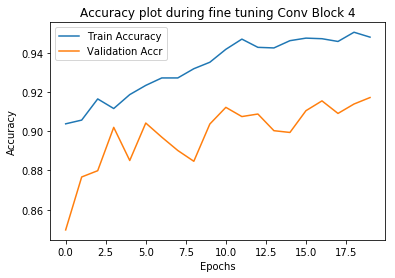

In [30]:
#The metrics of each epoch till this point are stored in train_log file
loss , acc, val_loss, val_acc = extract_metric('fine_tune_log_2.txt')
from matplotlib import pyplot as plt
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accr')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy plot during fine tuning Conv Block 4')

Text(0.5, 1.0, 'Loss plot during fine tuning Conv Block 4')

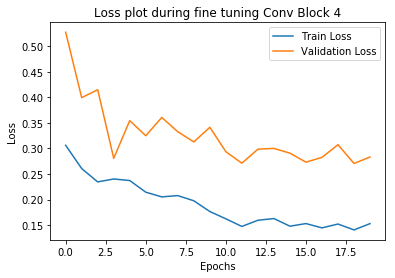

In [31]:
loss , acc, val_loss, val_acc = extract_metric('fine_tune_log_2.txt')
from matplotlib import pyplot as plt
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss plot during fine tuning Conv Block 4')

In [113]:
temp_model.save('keras_aug_4_15_3.h5')

# Fine tuning Convolution Block3

In [10]:
temp_model = keras.models.load_model('keras_aug_4_15_3.h5')
for layer in temp_model.layers:
    if layer.name == 'vgg19':
        layer.trainable = True
        #print(layer.name)
        for each_layer in layer.layers:
            #print(each_layer.name)
            if each_layer.name == 'block4_conv1' or each_layer.name == 'block4_conv2' or each_layer.name == 'block4_conv3' or each_layer.name == 'block4_conv4':
                each_layer.trainable = True
            elif each_layer.name == 'block5_conv1' or each_layer.name == 'block5_conv2' or each_layer.name == 'block5_conv3' or each_layer.name == 'block5_conv4':
                #print(each_layer.name)
                each_layer.trainable = True
            elif each_layer.name == 'block3_conv1' or each_layer.name == 'block3_conv2' or each_layer.name == 'block3_conv3' or each_layer.name == 'block3_conv4':
                #print(each_layer.name)
                each_layer.trainable = True
            else:
                #print(each_layer.name)
                each_layer.trainable = False
temp_model.compile(optimizer=optimizers.RMSprop(lr=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
temp_model.evaluate_generator(val_generator, steps = 30)

[0.29492049451852054, 0.9155701754385965]

In [12]:
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 20,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/20
100/100 [==============================] - 123s 1s/step - loss: 0.2212 - acc: 0.9247 - val_loss: 0.3495 - val_acc: 0.9020
Epoch 2/20
100/100 [==============================] - 109s 1s/step - loss: 0.2068 - acc: 0.9275 - val_loss: 0.2553 - val_acc: 0.9107
Epoch 3/20
100/100 [==============================] - 110s 1s/step - loss: 0.1929 - acc: 0.9332 - val_loss: 0.2902 - val_acc: 0.8986
Epoch 4/20
100/100 [==============================] - 108s 1s/step - loss: 0.1821 - acc: 0.9347 - val_loss: 0.2671 - val_acc: 0.9257
Epoch 5/20
100/100 [==============================] - 108s 1s/step - loss: 0.1767 - acc: 0.9400 - val_loss: 0.2349 - val_acc: 0.9318
Epoch 6/20
100/100 [==============================] - 111s 1s/step - loss: 0.1816 - acc: 0.9357 - val_loss: 0.2439 - val_acc: 0.9189
Epoch 7/20
100/100 [==============================] - 108s 1s/step - loss: 0.1745 - acc: 0.9404 - val_loss: 0.2074 - val_acc: 0.9240
Epoch 8/20
100/100 [==============================] - 111s 1s/step - 

In [13]:
temp_model.save('keras_aug_4_15_4.h5')

Training the same model with reduced learning rate of 0.000001

In [16]:
temp_model = keras.models.load_model('keras_aug_4_15_4.h5')
temp_model.compile(optimizer=optimizers.RMSprop(lr=0.000001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/5
100/100 [==============================] - 113s 1s/step - loss: 0.1025 - acc: 0.9639 - val_loss: 0.2079 - val_acc: 0.9476
Epoch 2/5
100/100 [==============================] - 109s 1s/step - loss: 0.1010 - acc: 0.9627 - val_loss: 0.1871 - val_acc: 0.9432
Epoch 3/5
100/100 [==============================] - 109s 1s/step - loss: 0.1036 - acc: 0.9626 - val_loss: 0.2077 - val_acc: 0.9375
Epoch 4/5
100/100 [==============================] - 108s 1s/step - loss: 0.0978 - acc: 0.9685 - val_loss: 0.1820 - val_acc: 0.9409
Epoch 5/5
100/100 [==============================] - 107s 1s/step - loss: 0.0925 - acc: 0.9663 - val_loss: 0.2093 - val_acc: 0.9432


In [19]:
temp_model.save('keras_aug_4_15_5.h5')

Text(0.5, 1.0, 'Accuracy plot during fine tuning Conv Block 3')

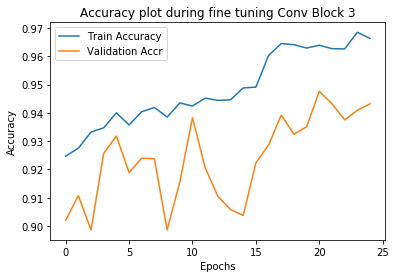

In [32]:
#The metrics of each epoch till this point are stored in train_log file
loss , acc, val_loss, val_acc = extract_metric('fine_tune_log_3.txt')
from matplotlib import pyplot as plt
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accr')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy plot during fine tuning Conv Block 3')

Text(0.5, 1.0, 'Loss plot during fine tuning Conv Block 3')

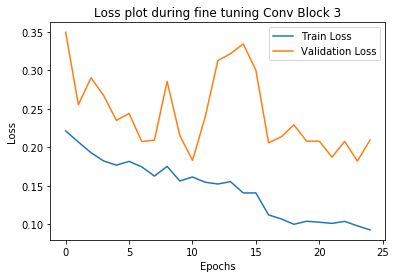

In [33]:
loss , acc, val_loss, val_acc = extract_metric('fine_tune_log_3.txt')
from matplotlib import pyplot as plt
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss plot during fine tuning Conv Block 3')

# Fine tuning by unfreezing Block2

In [65]:
temp_model = keras.models.load_model('keras_aug_4_15_5.h5')
for layer in temp_model.layers:
    if layer.name == 'vgg19':
        layer.trainable = True
        #print(layer.name)
        for each_layer in layer.layers:
            #print(each_layer.name)
            if each_layer.name == 'block4_conv1' or each_layer.name == 'block4_conv2' or each_layer.name == 'block4_conv3' or each_layer.name == 'block4_conv4':
                each_layer.trainable = True
            elif each_layer.name == 'block5_conv1' or each_layer.name == 'block5_conv2' or each_layer.name == 'block5_conv3' or each_layer.name == 'block5_conv4':
                #print(each_layer.name)
                each_layer.trainable = True
            elif each_layer.name == 'block3_conv1' or each_layer.name == 'block3_conv2' or each_layer.name == 'block3_conv3' or each_layer.name == 'block3_conv4':
                #print(each_layer.name)
                each_layer.trainable = True
            elif each_layer.name == 'block2_conv1' or each_layer.name == 'block2_conv2':
                each_layer.trainable = True
            else:
                #print(each_layer.name)
                each_layer.trainable = False
temp_model.compile(optimizer=optimizers.RMSprop(lr=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 10,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/10
100/100 [==============================] - 113s 1s/step - loss: 0.1519 - acc: 0.9482 - val_loss: 0.2193 - val_acc: 0.9358
Epoch 2/10
100/100 [==============================] - 109s 1s/step - loss: 0.1407 - acc: 0.9501 - val_loss: 0.2775 - val_acc: 0.9188
Epoch 3/10
100/100 [==============================] - 108s 1s/step - loss: 0.1397 - acc: 0.9472 - val_loss: 0.2425 - val_acc: 0.9307
Epoch 4/10
100/100 [==============================] - 111s 1s/step - loss: 0.1271 - acc: 0.9543 - val_loss: 0.1816 - val_acc: 0.9392
Epoch 5/10
100/100 [==============================] - 110s 1s/step - loss: 0.1323 - acc: 0.9525 - val_loss: 0.2286 - val_acc: 0.9399
Epoch 6/10
100/100 [==============================] - 108s 1s/step - loss: 0.1324 - acc: 0.9545 - val_loss: 0.2676 - val_acc: 0.9037
Epoch 7/10
100/100 [==============================] - 109s 1s/step - loss: 0.1268 - acc: 0.9548 - val_loss: 0.2042 - val_acc: 0.9392
Epoch 8/10
100/100 [==============================] - 109s 1s/step - 

In [67]:
temp_model.save('keras_aug_4_15_6.h5')

In [68]:
temp_model.compile(optimizer=optimizers.RMSprop(lr=0.000001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/5
100/100 [==============================] - 116s 1s/step - loss: 0.0991 - acc: 0.9661 - val_loss: 0.2038 - val_acc: 0.9497
Epoch 2/5
100/100 [==============================] - 106s 1s/step - loss: 0.0866 - acc: 0.9687 - val_loss: 0.2317 - val_acc: 0.9561
Epoch 3/5
100/100 [==============================] - 112s 1s/step - loss: 0.0814 - acc: 0.9701 - val_loss: 0.1832 - val_acc: 0.9611
Epoch 4/5
100/100 [==============================] - 108s 1s/step - loss: 0.0825 - acc: 0.9699 - val_loss: 0.2105 - val_acc: 0.9529
Epoch 5/5
100/100 [==============================] - 108s 1s/step - loss: 0.0762 - acc: 0.9728 - val_loss: 0.1802 - val_acc: 0.9611


In [69]:
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/5
100/100 [==============================] - 112s 1s/step - loss: 0.0779 - acc: 0.9732 - val_loss: 0.2297 - val_acc: 0.9578
Epoch 2/5
100/100 [==============================] - 108s 1s/step - loss: 0.0850 - acc: 0.9705 - val_loss: 0.1682 - val_acc: 0.9594
Epoch 3/5
100/100 [==============================] - 108s 1s/step - loss: 0.0777 - acc: 0.9714 - val_loss: 0.2382 - val_acc: 0.9544
Epoch 4/5
100/100 [==============================] - 109s 1s/step - loss: 0.0821 - acc: 0.9706 - val_loss: 0.2381 - val_acc: 0.9493
Epoch 5/5
100/100 [==============================] - 108s 1s/step - loss: 0.0801 - acc: 0.9706 - val_loss: 0.1542 - val_acc: 0.9545


In [70]:
temp_model.save('keras_aug_4_15_7.h5')

In [72]:
temp_model = keras.models.load_model('keras_aug_4_15_7.h5')
temp_model.compile(optimizer=optimizers.RMSprop(lr=0.0000005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/5
100/100 [==============================] - 114s 1s/step - loss: 0.0781 - acc: 0.9727 - val_loss: 0.2002 - val_acc: 0.9493
Epoch 2/5
100/100 [==============================] - 106s 1s/step - loss: 0.0714 - acc: 0.9751 - val_loss: 0.2177 - val_acc: 0.9464
Epoch 3/5
100/100 [==============================] - 107s 1s/step - loss: 0.0795 - acc: 0.9741 - val_loss: 0.1789 - val_acc: 0.9561
Epoch 4/5
100/100 [==============================] - 107s 1s/step - loss: 0.0790 - acc: 0.9734 - val_loss: 0.2026 - val_acc: 0.9561
Epoch 5/5
100/100 [==============================] - 111s 1s/step - loss: 0.0677 - acc: 0.9768 - val_loss: 0.2042 - val_acc: 0.9562


In [73]:
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/5
100/100 [==============================] - 111s 1s/step - loss: 0.0660 - acc: 0.9766 - val_loss: 0.2013 - val_acc: 0.9544
Epoch 2/5
100/100 [==============================] - 109s 1s/step - loss: 0.0699 - acc: 0.9735 - val_loss: 0.2363 - val_acc: 0.9510
Epoch 3/5
100/100 [==============================] - 110s 1s/step - loss: 0.0763 - acc: 0.9733 - val_loss: 0.1729 - val_acc: 0.9562
Epoch 4/5
100/100 [==============================] - 110s 1s/step - loss: 0.0726 - acc: 0.9731 - val_loss: 0.1764 - val_acc: 0.9611
Epoch 5/5
100/100 [==============================] - 109s 1s/step - loss: 0.0765 - acc: 0.9748 - val_loss: 0.2243 - val_acc: 0.9544


In [74]:
temp_model.save('keras_aug_4_15_8.h5')

Text(0.5, 1.0, 'Accuracy plot during fine tuning Conv Block 2')

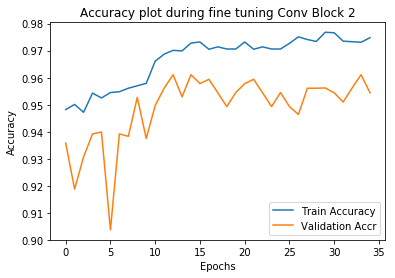

In [35]:
#The metrics of each epoch till this point are stored in train_log file
loss , acc, val_loss, val_acc = extract_metric('fine_tune_log_4.txt')
from matplotlib import pyplot as plt
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accr')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy plot during fine tuning Conv Block 2')

Text(0.5, 1.0, 'Loss plot during fine tuning Conv Block 2')

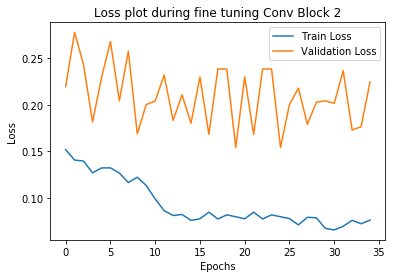

In [34]:
loss , acc, val_loss, val_acc = extract_metric('fine_tune_log_4.txt')
from matplotlib import pyplot as plt
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss plot during fine tuning Conv Block 2')

# Fine Tuning Convolution Block 1

In [76]:
temp_model = keras.models.load_model('keras_aug_4_15_8.h5')
for layer in temp_model.layers:
    if layer.name == 'vgg19':
        layer.trainable = True
temp_model.compile(optimizer=optimizers.RMSprop(lr=0.000005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/5
100/100 [==============================] - 112s 1s/step - loss: 0.0967 - acc: 0.9688 - val_loss: 0.2539 - val_acc: 0.9409
Epoch 2/5
100/100 [==============================] - 106s 1s/step - loss: 0.0934 - acc: 0.9655 - val_loss: 0.2326 - val_acc: 0.9448
Epoch 3/5
100/100 [==============================] - 110s 1s/step - loss: 0.0924 - acc: 0.9687 - val_loss: 0.2288 - val_acc: 0.9392
Epoch 4/5
100/100 [==============================] - 106s 1s/step - loss: 0.0900 - acc: 0.9677 - val_loss: 0.2095 - val_acc: 0.9510
Epoch 5/5
100/100 [==============================] - 108s 1s/step - loss: 0.0811 - acc: 0.9704 - val_loss: 0.1930 - val_acc: 0.9594


In [77]:
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 200,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator,
      callbacks=callbacks_list,
      )

Epoch 1/5
200/200 [==============================] - 221s 1s/step - loss: 0.0855 - acc: 0.9676 - val_loss: 0.2389 - val_acc: 0.9399
Epoch 2/5
200/200 [==============================] - 215s 1s/step - loss: 0.0816 - acc: 0.9724 - val_loss: 0.2690 - val_acc: 0.9409
Epoch 3/5
200/200 [==============================] - 216s 1s/step - loss: 0.0813 - acc: 0.9711 - val_loss: 0.1873 - val_acc: 0.9527
Epoch 4/5
200/200 [==============================] - 217s 1s/step - loss: 0.0804 - acc: 0.9718 - val_loss: 0.2531 - val_acc: 0.9529
Epoch 5/5
200/200 [==============================] - 217s 1s/step - loss: 0.0788 - acc: 0.9724 - val_loss: 0.2121 - val_acc: 0.9459


In [79]:
temp_model.save('keras_aug_4_15_9.h5')

In [78]:
from keras.models import load_model
test_model = load_model('keras_aug_4_15_8.h5')
predictions = test_model.predict(test_data)
predicted_classes = [reverse_class_dict[x] for x in np.argmax(predictions, axis=1)]
submission = pd.DataFrame({'file':test_ids,'species':predicted_classes})
submission.to_csv('keras_aug_4_15_8.csv', encoding="utf8", index=False)
from IPython.display import FileLink
FileLink('keras_aug_4_15_8.csv')

/home/marinenivenkatanaidu/NeuralNetworks/keras_aug_4_15_8.csv

In [80]:
from keras.models import load_model
test_model = load_model('keras_aug_4_15_9.h5')
predictions = test_model.predict(test_data)
predicted_classes = [reverse_class_dict[x] for x in np.argmax(predictions, axis=1)]
submission = pd.DataFrame({'file':test_ids,'species':predicted_classes})
submission.to_csv('keras_aug_4_15_9.csv', encoding="utf8", index=False)
from IPython.display import FileLink
FileLink('keras_aug_4_15_9.csv')

/home/marinenivenkatanaidu/NeuralNetworks/keras_aug_4_15_9.csv

In [9]:
temp_model = keras.models.load_model('keras_aug_4_15_9.h5')
for layer in temp_model.layers:
    if layer.name == 'vgg19':
        layer.trainable = True
temp_model.compile(optimizer=optimizers.RMSprop(lr=0.000001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator
      )

Epoch 1/5
100/100 [==============================] - 113s 1s/step - loss: 0.0614 - acc: 0.9806 - val_loss: 0.2496 - val_acc: 0.9513
Epoch 2/5
100/100 [==============================] - 108s 1s/step - loss: 0.0659 - acc: 0.9775 - val_loss: 0.1898 - val_acc: 0.9561
Epoch 3/5
100/100 [==============================] - 107s 1s/step - loss: 0.0634 - acc: 0.9781 - val_loss: 0.2377 - val_acc: 0.9595
Epoch 4/5
100/100 [==============================] - 110s 1s/step - loss: 0.0577 - acc: 0.9783 - val_loss: 0.2136 - val_acc: 0.9643
Epoch 5/5
100/100 [==============================] - 108s 1s/step - loss: 0.0634 - acc: 0.9769 - val_loss: 0.2089 - val_acc: 0.9578


In [10]:
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator
      )

Epoch 1/5
100/100 [==============================] - 114s 1s/step - loss: 0.0594 - acc: 0.9803 - val_loss: 0.2529 - val_acc: 0.9527
Epoch 2/5
100/100 [==============================] - 107s 1s/step - loss: 0.0578 - acc: 0.9806 - val_loss: 0.2502 - val_acc: 0.9513
Epoch 3/5
100/100 [==============================] - 109s 1s/step - loss: 0.0586 - acc: 0.9795 - val_loss: 0.2288 - val_acc: 0.9493
Epoch 4/5
100/100 [==============================] - 111s 1s/step - loss: 0.0553 - acc: 0.9800 - val_loss: 0.2281 - val_acc: 0.9578
Epoch 5/5
100/100 [==============================] - 108s 1s/step - loss: 0.0553 - acc: 0.9802 - val_loss: 0.2403 - val_acc: 0.9545


In [11]:
temp_model.save('keras_aug_4_15_10.h5')

In [13]:
temp_model.compile(optimizer=optimizers.RMSprop(lr=0.000001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator
      )

Epoch 1/5
100/100 [==============================] - 112s 1s/step - loss: 0.0574 - acc: 0.9812 - val_loss: 0.2736 - val_acc: 0.9578
Epoch 2/5
100/100 [==============================] - 108s 1s/step - loss: 0.0560 - acc: 0.9793 - val_loss: 0.1809 - val_acc: 0.9611
Epoch 3/5
100/100 [==============================] - 108s 1s/step - loss: 0.0532 - acc: 0.9817 - val_loss: 0.2502 - val_acc: 0.9594
Epoch 4/5
100/100 [==============================] - 108s 1s/step - loss: 0.0547 - acc: 0.9812 - val_loss: 0.2580 - val_acc: 0.9493
Epoch 5/5
100/100 [==============================] - 107s 1s/step - loss: 0.0564 - acc: 0.9812 - val_loss: 0.1978 - val_acc: 0.9595


In [14]:
temp_model.save('keras_aug_4_15_11.h5')

In [21]:
from keras.models import load_model
import pandas as pd
test_model = load_model('keras_aug_4_15_11.h5')
predictions = test_model.predict(test_data)
predicted_classes = [reverse_class_dict[x] for x in np.argmax(predictions, axis=1)]
submission = pd.DataFrame({'file':test_ids,'species':predicted_classes})
submission.to_csv('keras_aug_4_15_11.csv', encoding="utf8", index=False)
from IPython.display import FileLink
FileLink('keras_aug_4_15_11.csv')

/home/marinenivenkatanaidu/NeuralNetworks/keras_aug_4_15_11.csv

In [22]:
temp_model = keras.models.load_model('keras_aug_4_15_11.h5')
temp_model.compile(optimizer=optimizers.RMSprop(lr=0.000001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator
      )

Epoch 1/5
100/100 [==============================] - 115s 1s/step - loss: 0.0553 - acc: 0.9813 - val_loss: 0.2593 - val_acc: 0.9545
Epoch 2/5
100/100 [==============================] - 108s 1s/step - loss: 0.0584 - acc: 0.9812 - val_loss: 0.2155 - val_acc: 0.9578
Epoch 3/5
100/100 [==============================] - 107s 1s/step - loss: 0.0516 - acc: 0.9827 - val_loss: 0.2387 - val_acc: 0.9510
Epoch 4/5
100/100 [==============================] - 108s 1s/step - loss: 0.0548 - acc: 0.9808 - val_loss: 0.2250 - val_acc: 0.9610
Epoch 5/5
100/100 [==============================] - 110s 1s/step - loss: 0.0446 - acc: 0.9841 - val_loss: 0.2008 - val_acc: 0.9578


In [23]:
history = temp_model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs= 5,
      validation_steps = 20,
      validation_data = val_generator
      )

Epoch 1/5
100/100 [==============================] - 112s 1s/step - loss: 0.0534 - acc: 0.9816 - val_loss: 0.2974 - val_acc: 0.9544
Epoch 2/5
100/100 [==============================] - 111s 1s/step - loss: 0.0559 - acc: 0.9804 - val_loss: 0.2267 - val_acc: 0.9562
Epoch 3/5
100/100 [==============================] - 107s 1s/step - loss: 0.0530 - acc: 0.9819 - val_loss: 0.2249 - val_acc: 0.9561
Epoch 4/5
100/100 [==============================] - 107s 1s/step - loss: 0.0512 - acc: 0.9810 - val_loss: 0.2510 - val_acc: 0.9611
Epoch 5/5
100/100 [==============================] - 109s 1s/step - loss: 0.0506 - acc: 0.9820 - val_loss: 0.1958 - val_acc: 0.9610


In [26]:
temp_model.save('keras_aug_4_15_12.h5')

Text(0.5, 1.0, 'Accuracy plot during fine tuning Conv Block 1')

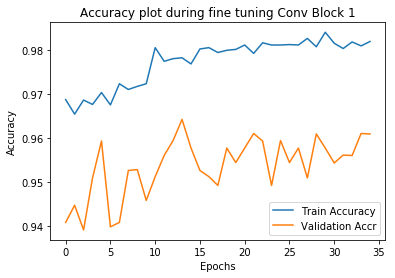

In [36]:
#The metrics of each epoch till this point are stored in train_log file
loss , acc, val_loss, val_acc = extract_metric('fine_tune_log_5.txt')
from matplotlib import pyplot as plt
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accr')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy plot during fine tuning Conv Block 1')

Text(0.5, 1.0, 'Loss plot during fine tuning Conv Block 1')

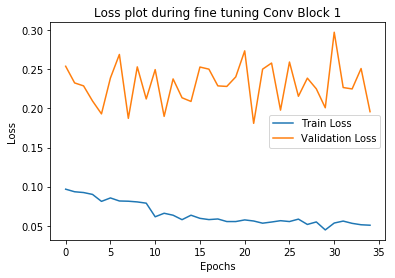

In [37]:
loss , acc, val_loss, val_acc = extract_metric('fine_tune_log_5.txt')
from matplotlib import pyplot as plt
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss plot during fine tuning Conv Block 1')

Text(0.5, 1.0, 'Accuracy plot during entire training')

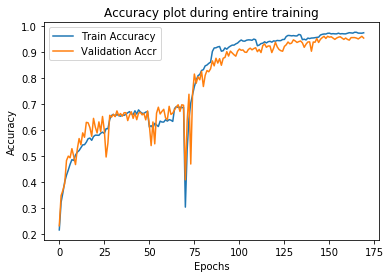

In [38]:
loss = []
acc = []
val_loss = []
val_acc = []
temp_loss , temp_acc, temp_val_loss, temp_val_acc = extract_metric('train_log_0.txt')
loss = loss + temp_loss
acc= acc + temp_acc
val_loss = val_loss + temp_val_loss
val_acc = val_acc + temp_val_acc
temp_loss , temp_acc, temp_val_loss, temp_val_acc = extract_metric('fine_tune_log_1.txt')
loss = loss + temp_loss
acc= acc + temp_acc
val_loss = val_loss + temp_val_loss
val_acc = val_acc + temp_val_acc
temp_loss , temp_acc, temp_val_loss, temp_val_acc = extract_metric('fine_tune_log_2.txt')
loss = loss + temp_loss
acc= acc + temp_acc
val_loss = val_loss + temp_val_loss
val_acc = val_acc + temp_val_acc
temp_loss , temp_acc, temp_val_loss, temp_val_acc = extract_metric('fine_tune_log_3.txt')
loss = loss + temp_loss
acc= acc + temp_acc
val_loss = val_loss + temp_val_loss
val_acc = val_acc + temp_val_acc
temp_loss , temp_acc, temp_val_loss, temp_val_acc = extract_metric('fine_tune_log_4.txt')
loss = loss + temp_loss
acc= acc + temp_acc
val_loss = val_loss + temp_val_loss
val_acc = val_acc + temp_val_acc
from matplotlib import pyplot as plt
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accr')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy plot during entire training')

Text(0.5, 1.0, 'Loss plot during entire training')

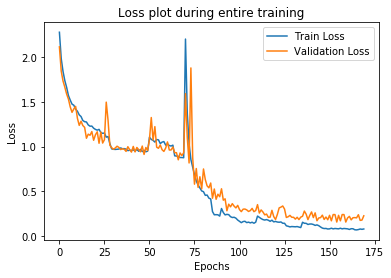

In [39]:
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss plot during entire training')

# Testing the Model with test Data

The model learnt till now was evaluated with the test data and the predictions were submitted to the kaggle to find the prediction accuracy. The test accuracy observed is 93.8%

In [17]:
val_generator.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [19]:
reverse_class_dict

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

In [18]:
class_dict = val_generator.class_indices
reverse_class_dict = {}
for i in class_dict:
    reverse_class_dict[class_dict[i]] = i

In [16]:
#Read the test images and translate the images data into a numpy array
test_count = len(os.listdir(test_dir))
test_data = np.zeros(shape=[test_count, rsltn, rsltn, 3])
test_ids = []
curr_idx = 0
for each_file in os.listdir(test_dir):
    test_ids.append(each_file)
    pic = image.load_img(os.path.join(test_dir, each_file), target_size=(rsltn, rsltn))
    x = image.img_to_array(pic)
    x = x/255
    test_data[curr_idx, :] = x
    curr_idx += 1
    
from keras.models import load_model
test_model = load_model('keras_aug_4_15_5.h5')
predictions = test_model.predict(test_data)
predicted_classes = [reverse_class_dict[x] for x in np.argmax(predictions, axis=1)]

NameError: name 'reverse_class_dict' is not defined

In [43]:
predictions.shape

(794, 12)

In [44]:
from os.path import basename
import pandas as pd
#test_ids = [basename(x) for x in os.listdir(test_dir)]
submission = pd.DataFrame({'file':test_ids,'species':predicted_classes})
submission.to_csv('keras_aug_4_15_5.csv', encoding="utf8", index=False)
from IPython.display import FileLink
FileLink('keras_aug_4_15_5.csv')

/home/marinenivenkatanaidu/NeuralNetworks/keras_aug_4_15_5.csv

In [27]:
from keras.models import load_model
import pandas as pd
test_model = load_model('keras_aug_4_15_12.h5')
predictions = test_model.predict(test_data)
predicted_classes = [reverse_class_dict[x] for x in np.argmax(predictions, axis=1)]
submission = pd.DataFrame({'file':test_ids,'species':predicted_classes})
submission.to_csv('keras_aug_4_15_12.csv', encoding="utf8", index=False)
from IPython.display import FileLink
FileLink('keras_aug_4_15_12.csv')

/home/marinenivenkatanaidu/NeuralNetworks/keras_aug_4_15_12.csv